In [3]:
import numpy as np
import pandas as pd
import copy
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
pd.set_option('future.no_silent_downcasting', True)

# Read in crop data
treatments = np.array(['T1', 'T2', 'T3', 'T4'])
treatment_mapping = {treatments[0]: 0, treatments[1]: 1,\
                      treatments[2]: 2, treatments[3]: 3}
crops = np.array(['Zea mays L.', 'Triticum aestivum L.', \
                  'Glycine max L.'])
crop_mapping = {crops[0]: 0, crops[1]: 1,\
                      crops[2]: 2,}

data = pd.read_csv('cleaned_agronomic_data.csv')[['year', 'treatment', 'crop', 'crop_only_yield_kg_ha']]

data['treatment'] = data['treatment'].replace(treatment_mapping)
data['crop'] = data['crop'].replace(crop_mapping)

data = data[data['treatment'].isin([0,1,2,3])]

years = data['year'].unique()

filtered_years = []
filtered_crops = []
filtered_actions = []
for year in years:
    for crop in (data[data['year'] == year])['crop'].unique():
        for action in range(4):
            if len(data.loc[(data['year'] == year) \
                            & (data['treatment'] == action) \
                            & (data['crop'] == crop), \
                            'crop_only_yield_kg_ha']) < 6:
                filtered_years.append(year)
                filtered_crops.append(crop)
                filtered_actions.append(action)

filtered = pd.DataFrame({
    "year": filtered_years,
    "crop": filtered_crops,
    'treatment': filtered_actions
})

filtered=filtered.sort_values(['year','crop'])
                


average_yields = (
    data.groupby(['year', 'treatment', 'crop'])['crop_only_yield_kg_ha']
    .mean()
    .reset_index()
)

average_yields=average_yields.sort_values(['year', 'crop'])

list_of_years = average_yields['year'].unique()
# for year in years:
#     for crop in (average_yields[average_yields['year'] == year])['crop'].unique():
#         list_of_years.append(year)

In [477]:
average_yields.head(50)

,year,treatment,crop,crop_only_yield_kg_ha
0,1989,0,0,7905.833333
1,1989,1,0,8112.500000
2,1989,2,1,1993.166667
3,1989,3,1,1957.833333
6,1990,2,0,4546.000000
7,1990,3,0,4642.166667
4,1990,0,2,2841.333333
5,1990,1,2,2973.166667
8,1991,0,0,8325.500000
9,1991,1,0,8025.750000


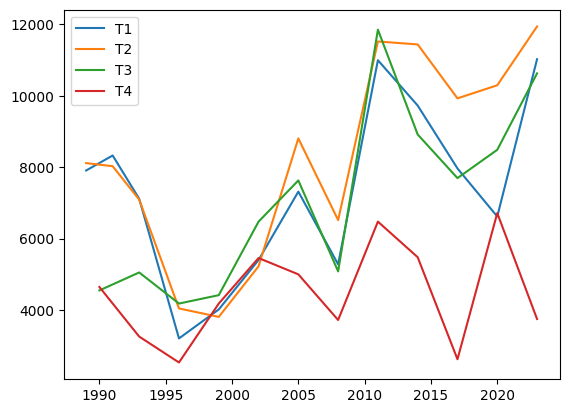

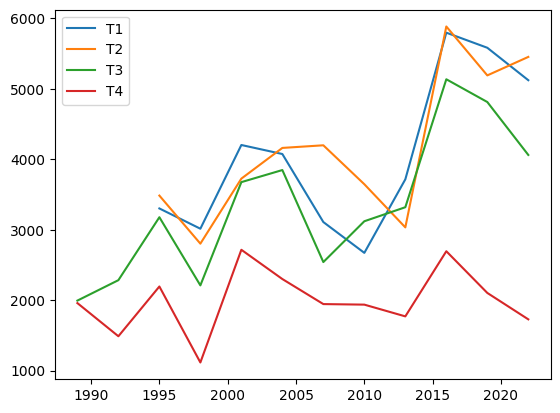

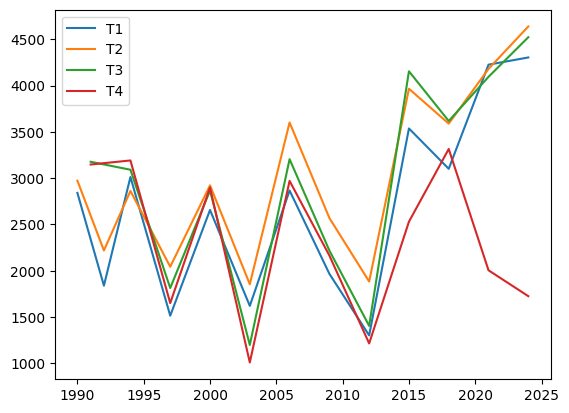

In [471]:
import matplotlib.pyplot as plt

for crop in range(3):
    years_to_plot = [[], [], [], []]
    a0_to_plot = []
    a1_to_plot = []
    a2_to_plot = []
    a3_to_plot = []

    actions_to_plot = [a0_to_plot, a1_to_plot, a2_to_plot, a3_to_plot]
    for index, row in average_yields.iterrows():
        if row['crop'] == crop:
            actions_to_plot[row['treatment'].astype(int)].append(row['crop_only_yield_kg_ha'])
            years_to_plot[row['treatment'].astype(int)].append(row['year'])

    plt.plot(years_to_plot[0], a0_to_plot,label='T1')
    plt.plot(years_to_plot[1], a1_to_plot,label='T2')
    plt.plot(years_to_plot[2], a2_to_plot,label='T3')
    plt.plot(years_to_plot[3], a3_to_plot,label='T4')
    plt.legend()
    plt.show()

In [455]:
def not_enough_replicates_finder(year, crop, treatment, filtered):
    return ((filtered[['year', 'crop', 'treatment']].values == [year, crop, treatment]).all(axis=1)).any()

In [ ]:
def restricted_epsilon_greedy(df, epsilon, conditional=False):
    '''
    Operating on the event that we can actually sample 2*T timesteps
    '''
    arm_counters_by_crop = [np.zeros(4), np.zeros(4), np.zeros(4)]
    arm_rewards_by_crop = [np.zeros(4), np.zeros(4), np.zeros(4)]
    years = df['year'].unique()
    dataset = []
    coin_flips = []
    for year in years:
        crop = np.random.choice((df[df['year'] == year])['crop'].unique())

            if np.any(arm_counters_by_crop[crop] == 0.):
                argmax = 'undecided'
            else:
                argmax = np.argmax(arm_rewards_by_crop[crop]/arm_counters_by_crop[crop])


            disallowed_actions = np.array([False,False,False,False])
            for possible_action in range(4):
                if not_enough_replicates_finder(year, crop, possible_action, filtered):
                    disallowed_actions[possible_action] = True

            p = np.full(4, epsilon/4)
            if argmax != 'undecided':
                if disallowed_actions[argmax]:
                    p[disallowed_actions] = 0.
                    p = p/p.sum()
                else:
                    p[disallowed_actions] = 0.
                    p[~disallowed_actions] = epsilon/(4-disallowed_actions.sum())
                    p[argmax] += 1-epsilon
            else:
                p[disallowed_actions] = 0.
                p = p/p.sum()
            
            u = np.random.uniform()
            cumulative = np.cumsum(p)
            action = np.searchsorted(cumulative, u)

            reward = df.loc[(df['year'] == year) \
                            & (df['treatment'] == action) \
                            & (df['crop'] == crop), \
                            'crop_only_yield_kg_ha'].iloc[0]
            dataset.append([crop,action,reward])

            arm_counters_by_crop[crop][action] += 1
            arm_rewards_by_crop[crop][action] += reward

            if conditional:
                coin_flips.append(u)
    if not conditional:
        return dataset
    else:
        return dataset, coin_flips

In [457]:
def get_data_weight(data, epsilon, conditional=False, coin_flips=None):

    if data == 'flag':
        return 0.
    arm_counters_by_crop = [np.zeros(4), np.zeros(4), np.zeros(4)]
    arm_rewards_by_crop = [np.zeros(4), np.zeros(4), np.zeros(4)]

    horizon = len(data)
    prob = 1.
    
    for t in range(horizon):
        [crop,action,reward] = data[t]
        
        if np.any(arm_counters_by_crop[crop] == 0.):
            argmax = 'undecided'
        else:
            argmax = np.argmax(arm_rewards_by_crop[crop]/arm_counters_by_crop[crop])

        disallowed_actions = np.array([False,False,False,False])
        for possible_action in range(4):
            if not_enough_replicates_finder(list_of_years[t], crop, possible_action, filtered):
                disallowed_actions[possible_action] = True
        
        p = np.full(4, epsilon/4)
        if argmax != 'undecided':
            if disallowed_actions[argmax]:
                p[disallowed_actions] = 0.
                p = p/p.sum()
            else:
                p[disallowed_actions] = 0.
                p[~disallowed_actions] = epsilon/(4-disallowed_actions.sum())
                p[argmax] += 1-epsilon
        else:
            p[disallowed_actions] = 0.
            p = p/p.sum()

        #print("weight time", t, p, argmax)
        if conditional:
            u = coin_flips[t]
            cumulative = np.cumsum(p)
            action_to_select = np.searchsorted(cumulative, u)

            if action_to_select != action:
                return 0.
        else:
            prob *= p[action]


        arm_counters_by_crop[crop][action] += 1
        arm_rewards_by_crop[crop][action] += reward
    
    if not conditional:
        return prob
    else:
        return 1.

In [458]:
def imitation_X(data, null_hypothesis_g, propose_or_weight, epsilon):
    '''This sampling scheme samples X's from the simulation 
    distribution over X's'''
    '''The input propose_or_weight is True if doing sampling, 
    and False if calculating the weight'''
    T = len(data)
    
    prob = 1.
    if propose_or_weight:
        sampled_data = []

    arm_counters_by_crop = [np.zeros(4), np.zeros(4), np.zeros(4)]
    arm_rewards_by_crop = [np.zeros(4), np.zeros(4), np.zeros(4)]

    for t in range(T):
        [crop,action,reward] = data[t]
        
        if np.any(arm_counters_by_crop[crop] == 0.):
            argmax = 'undecided'
        else:
            argmax = np.argmax(arm_rewards_by_crop[crop]/arm_counters_by_crop[crop])

        disallowed_actions = np.array([False,False,False,False])
        for possible_action in range(4):
            if not_enough_replicates_finder(list_of_years[t], crop, possible_action, filtered):
                disallowed_actions[possible_action] = True
        
        p = np.full(4, epsilon/4)
        if argmax != 'undecided':
            if disallowed_actions[argmax]:
                p[disallowed_actions] = 0.
                p = p/p.sum()
            else:
                p[disallowed_actions] = 0.
                p[~disallowed_actions] = epsilon/(4-disallowed_actions.sum())
                p[argmax] += 1-epsilon
        else:
            p[disallowed_actions] = 0.
            p = p/p.sum()

        ps = np.zeros(4)

        for j in range(len(null_hypothesis_g)):
            if data[t][1] in null_hypothesis_g[j]:
                ps = copy.deepcopy(p)
                alt_inds = np.setdiff1d(np.arange(4),\
                                null_hypothesis_g[j])
                ps[alt_inds] = 0.
        
        ps = ps/np.sum(ps)

        # if proposing, then sample from new_p's distribution
        # otherwise set x to be the current x value and calculate
        # its weight using new_p
        if propose_or_weight:
            action = np.random.choice(4, p=ps)
        else:
            action = data[t][1]

        prob *= ps[action]
        
        if propose_or_weight:
            sampled_data.append([crop,action,reward])
        
        
        arm_counters_by_crop[crop][action] += 1
        arm_rewards_by_crop[crop][action] += reward

    if propose_or_weight:
        return sampled_data, prob
    else:
        return prob

In [459]:
def imitation(data, propose_or_weight, epsilon):
        ''''The imitation distribution samples without replacement, 
        proportional to the action-selection probabilities'''
        
        '''The input propose_or_weight is True if doing sampling, 
        and False if calculating the weight'''

        ''' Do it for each crop individually:'''

        T = len(data)

        prob = 1.
        
        arm_counters_by_crop = [np.zeros(4), np.zeros(4), np.zeros(4)]
        arm_rewards_by_crop = [np.zeros(4), np.zeros(4), np.zeros(4)]
        
        shuffled_data = []

        # pointer list of already-selected indices
        curr_selected = np.zeros(T)

        
        for i in range(T):
            [crop,action,reward] = data[i]
        
            if np.any(arm_counters_by_crop[crop] == 0.):
                argmax = 'undecided'
            else:
                argmax = np.argmax(arm_rewards_by_crop[crop]/arm_counters_by_crop[crop])

            disallowed_actions = np.array([False,False,False,False])
            for possible_action in range(4):
                if not_enough_replicates_finder(list_of_years[i], crop, possible_action, filtered):
                    disallowed_actions[possible_action] = True
            
            p = np.full(4, epsilon/4)
            if argmax != 'undecided':
                if disallowed_actions[argmax]:
                    p[disallowed_actions] = 0.
                    p = p/p.sum()
                else:
                    p[disallowed_actions] = 0.
                    p[~disallowed_actions] = epsilon/(4-disallowed_actions.sum())
                    p[argmax] += 1-epsilon
            else:
                p[disallowed_actions] = 0.
                p = p/p.sum()
            
            action_propensity = copy.deepcopy(p)
            # the new p is going to be dist over new timepionts
            p = np.zeros(T)
            
            # populate p-vector with weights corresponding to epsilon-greedy policy
            # among those remaining indices
            for i_ in range(T):
                if curr_selected[i_] != 1:
                    if data[i_][0] == crop:
                        p[i_] = action_propensity[data[i_][1]]

            # # otherwise select unif at random
            # if np.all(p==0):
            #     for i_ in range(T):
            #         if curr_selected[i_] == 0 and data[i_][0] == crop:
            #             p[i_] = 1.

            # normalize p-vector
            if np.sum(p) == 0.:
                return 'flag', 1.
            p = p/np.sum(p)
            
            # if proposing, then sample according to p, 
            # if calculating the weight, then calculate the 
            # probability of having selected ith index, using p
            if propose_or_weight:
                sample = np.random.choice(T, p=p)
            else:
                sample = i

            # mark sampled index in curr_selected so that we no longer sample it
            curr_selected[sample] = 1

            # add timestep to shuffled data if proposing
            # and update probability correspondingly, in either case
            if propose_or_weight:
                shuffled_data.append((data[sample][0], data[sample][1], data[sample][2]))
            prob *= p[sample]

            # update reward-action trackers
            
            arm_counters_by_crop[crop][data[sample][1]] += 1
            arm_rewards_by_crop[crop][data[sample][1]] += data[sample][2]
            # reward depends on b_ci, since data[sample][1] has subtracted it off
        
        if propose_or_weight:
            return shuffled_data, prob 
        else:
            return prob

In [460]:
def re_imitation(data, propose_or_weight, epsilon):
        ''''The re_imitation distribution samples, at each timestep, an action
        based on the previously selected data, epsilon-greedily and then samples 
        correspondingly from the remaining timesteps.'''

        T = len(data)

        prob = 1.
        
        arm_counters_by_crop = [np.zeros(4), np.zeros(4), np.zeros(4)]
        arm_rewards_by_crop = [np.zeros(4), np.zeros(4), np.zeros(4)]
        
        shuffled_data = []

        # pointer list of already-selected indices
        curr_selected = np.zeros(T)

        
        for i in range(T):
            [crop,action,reward] = data[i]
        
            if np.any(arm_counters_by_crop[crop] == 0.):
                argmax = 'undecided'
            else:
                argmax = np.argmax(arm_rewards_by_crop[crop]/arm_counters_by_crop[crop])

            disallowed_actions = np.array([False,False,False,False])
            for possible_action in range(4):
                if not_enough_replicates_finder(list_of_years[i], crop, possible_action, filtered):
                    disallowed_actions[possible_action] = True
            
            p = np.full(4, epsilon/4)
            if argmax != 'undecided':
                if disallowed_actions[argmax]:
                    p[disallowed_actions] = 0.
                    p = p/p.sum()
                else:
                    p[disallowed_actions] = 0.
                    p[~disallowed_actions] = epsilon/(4-disallowed_actions.sum())
                    p[argmax] += 1-epsilon
            else:
                p[disallowed_actions] = 0.
                p = p/p.sum()
            
            action_propensity = copy.deepcopy(p)


            # need to account for which actions remaining
            actions_remaining = np.zeros(4)
            for i_ in range(T):
                if curr_selected[i_] != 1 and data[i_][0] == crop:
                    actions_remaining[data[i_][1]] = 1.
            
            prob_vec = action_propensity * actions_remaining


            # ran out of options, so go to next resample regeneration
            if prob_vec.sum() == 0:
                return 'flag', 1.


            prob_vec = prob_vec / np.sum(prob_vec)

            # sample the action
            if propose_or_weight:
                action_to_take = np.random.choice(4, p=prob_vec)
            else:
                # in this case, the action_to_take was the action selected
                action_to_take = data[i][1]
            
            prob *= prob_vec[action_to_take]


            # the new p is going to be dist over new timepionts
            p = np.zeros(T)
            
            # populate p-vector with weights corresponding to epsilon-greedy policy
            # among those remaining indices
            for i_ in range(T):
                if curr_selected[i_] != 1:
                    if data[i_][0] == crop:
                        if data[i_][1] == action_to_take:
                            p[i_] = 1.

            # normalize p-vector
            p = p/np.sum(p)
            
            # if proposing, then sample according to p, 
            # if calculating the weight, then calculate the 
            # probability of having selected ith index, using p
            if propose_or_weight:
                sample = np.random.choice(T, p=p)
            else:
                sample = i

            # mark sampled index in curr_selected so that we no longer sample it
            curr_selected[sample] = 1

            # add timestep to shuffled data if proposing
            # and update probability correspondingly, in either case
            if propose_or_weight:
                shuffled_data.append((data[sample][0], data[sample][1], data[sample][2]))
            prob *= p[sample]

            # update reward-action trackers
            
            arm_counters_by_crop[crop][data[sample][1]] += 1
            arm_rewards_by_crop[crop][data[sample][1]] += data[sample][2]
            # reward depends on b_ci, since data[sample][1] has subtracted it off


        if propose_or_weight:
            return shuffled_data, prob 
        else:
            return prob

In [461]:
def cond_imitation(data, coin_flips, propose_or_weight, epsilon):
        ''''The cond_imitation distribution samples without replacement, 
        using the cond_imitation distribution'''
        
        '''The input propose_or_weight is True if doing sampling, 
        and False if calculating the weight'''

        T = len(data)

        prob = 1.
        
        arm_counters_by_crop = [np.zeros(4), np.zeros(4), np.zeros(4)]
        arm_rewards_by_crop = [np.zeros(4), np.zeros(4), np.zeros(4)]
        
        shuffled_data = []

        # pointer list of already-selected indices
        curr_selected = np.zeros(T)

        
        for i in range(T):
            u = coin_flips[i]
            [crop,action,reward] = data[i]
        
            if np.any(arm_counters_by_crop[crop] == 0.):
                argmax = 'undecided'
            else:
                argmax = np.argmax(arm_rewards_by_crop[crop]/arm_counters_by_crop[crop])

            disallowed_actions = np.array([False,False,False,False])
            for possible_action in range(4):
                if not_enough_replicates_finder(list_of_years[i], crop, possible_action, filtered):
                    disallowed_actions[possible_action] = True
            
            p = np.full(4, epsilon/4)
            if argmax != 'undecided':
                if disallowed_actions[argmax]:
                    p[disallowed_actions] = 0.
                    p = p/p.sum()
                else:
                    p[disallowed_actions] = 0.
                    p[~disallowed_actions] = epsilon/(4-disallowed_actions.sum())
                    p[argmax] += 1-epsilon
            else:
                p[disallowed_actions] = 0.
                p = p/p.sum()
            

            cumulative = np.cumsum(p)
            action_to_select = np.searchsorted(cumulative, u)

            # the new p is going to be dist over new timepionts
            p = np.zeros(T)
            
            # populate p-vector with weights corresponding to epsilon-greedy policy
            # among those remaining indices
            for i_ in range(T):
                if curr_selected[i_] != 1:
                    if data[i_][0] == crop:
                        if data[i_][1] == action_to_select:
                            p[i_] = 1.

            # normalize p-vector

            if p.sum() == 0:
                return 'flag', 1.

            p = p/np.sum(p)
            
            # if proposing, then sample according to p, 
            # if calculating the weight, then calculate the 
            # probability of having selected ith index, using p
            if propose_or_weight:
                sample = np.random.choice(T, p=p)
            else:
                sample = i

            # mark sampled index in curr_selected so that we no longer sample it
            curr_selected[sample] = 1

            # add timestep to shuffled data if proposing
            # and update probability correspondingly, in either case
            if propose_or_weight:
                shuffled_data.append((data[sample][0], data[sample][1], data[sample][2]))
            prob *= p[sample]

            # update reward-action trackers
            
            arm_counters_by_crop[crop][data[sample][1]] += 1
            arm_rewards_by_crop[crop][data[sample][1]] += data[sample][2]
            # reward depends on b_ci, since data[sample][1] has subtracted it off

        if propose_or_weight:
            return shuffled_data, prob 
        else:
            return prob

In [462]:
epsilon=0.1
data=restricted_epsilon_greedy(average_yields, epsilon, conditional=False)
resample,_=re_imitation(data,True, epsilon)
get_data_weight(resample, epsilon, conditional=False, coin_flips=None)

5.1519616067440346e-21

In [463]:
def get_proposal(data, null_hypothesis_g, style, epsilon, coin_flips=None):
    if style == 'i_X':
        return imitation_X(data, null_hypothesis_g, True, epsilon)


    if style == 'i':
        return imitation(data, True, epsilon)
    if style == 'r':
        return re_imitation(data, True, epsilon)
    if style == 'c':
        return cond_imitation(data, coin_flips, True, epsilon)
        


def get_proposal_weight(proposal, null_hypothesis_g, style, epsilon, coin_flips=None):
    if style == 'i_X':
        return imitation_X(proposal, null_hypothesis_g, False, epsilon)

    if style == 'i':
        return imitation(proposal, False, epsilon)
    if style == 'r':
        return re_imitation(proposal, False, epsilon)
    if style == 'c':
        return cond_imitation(proposal, coin_flips, False, epsilon)

In [464]:
def mc_construct_rand_p_value(data, null_hypothesis_g, test_stat, style, epsilon, num_samples=100):
    # p_plus and p_minus will be unnormalized p values; denominator
    # is the normalizing factor. We return the correctly normalized
    # p values at the end
    denominator = 0.
    p_plus = 0.
    p_minus = 0.


    s_id = test_stat(data, null_hypothesis_g)

    sample_prob_set = [get_proposal(data, null_hypothesis_g, style, epsilon) for i in tqdm(range(num_samples))]
    
    # the set of samples and probabilities for those samples, correspondingly
    sample_set = [sample_prob_set[i][0] for i in tqdm(range(num_samples))]
    prob_set = [sample_prob_set[i][1] for i in tqdm(range(num_samples))]


    # add the original data to the list of samples
    orig_data_probs = get_proposal_weight(data, null_hypothesis_g, style, epsilon)

    sample_set.append(data)
    prob_set.append(orig_data_probs)

    
    n_eff_denom = 0.

    ps = []

    # reverse order of list, because weights of actual resamples won't be 0 when under true data
    for ind in tqdm(list(reversed(list(range(len(sample_set)))))):
        sample = sample_set[ind]
        proba = prob_set[ind]
        s = test_stat(sample, null_hypothesis_g)

        weight = get_data_weight(sample, epsilon)

        # instead of simply calculating the product of all samples, 
        # recognize that the independence of all of our sampling schemes
        # guarantees that we may write the conditional probability of the
        # remaining M-1 samples given the ith as 
        # a_1 * a_2 * ... * a_{i-1}*a_{i+1}*... * a_M
        # = a_1 * a_2 * ... * a_M/a_i. The numerator a_1 * a_2 * ... * a_M
        # is constant and in the numerator and denominator and may thus be cancelled
        # so that we only need multiply by 1/a_i, the inverse of the ith proposal probability
        
        # need to behave differently if style involves simulation1, simulation2, or simulation3
        # permutations at first
        if style in ['s1s', 's2s', 's3s']:
            weight_list = []
            for second_ind in range(len(sample_set)):
                # don't want to include same index
                if second_ind != ind:
                    weight_list.append(get_proposal_weight(sample_set[second_ind],\
                            sample_set[ind], style, epsilon))

            # obtain the weight list at the first timestep so that we can divide all future ones
            # by it to ensure weights aren't too small
            weight_list.sort()
            if ind == len(sample_set)-1:
                first_weight_list = copy.deepcopy(weight_list)
                p_i = weight # just the first sample will have the resampling weight as 1 
                # because we divide by it
            else:
                p_i = np.prod(np.array(weight_list)/np.array(first_weight_list))*weight
        else:
            p_i = (1./proba)*weight
        
        ps.append(p_i) # appending to list so that denom calculation doesn't get too small

        denominator += p_i
        p_plus += p_i if s >= s_id else 0
        p_minus += p_i if s > s_id else 0
    
    ps = np.array(ps)
    ps = ps/np.sum(ps)
    n_eff_denom = np.sum(ps**2)

    return p_plus/denominator, p_minus/denominator, (1./n_eff_denom)/(num_samples+1)

In [465]:
def mc_nonstationarity_construct_rand_p_value(data, test_stat, style, epsilon, num_samples=100, coin_flips = None):
    # p_plus and p_minus will be unnormalized p values; denominator
    # is the normalizing factor. We return the correctly normalized
    # p values at the end
    denominator = 0.
    p_plus = 0.
    p_minus = 0.


    s_id = test_stat(data)

    if style != 'c':
        sample_prob_set = [get_proposal(data, None, style, epsilon) for i in tqdm(range(num_samples))]
    else:
        sample_prob_set = [get_proposal(data, None, style, epsilon, coin_flips) for i in tqdm(range(num_samples))]

    # the set of samples and probabilities for those samples, correspondingly
    sample_set = [sample_prob_set[i][0] for i in tqdm(range(num_samples))]
    prob_set = [sample_prob_set[i][1] for i in tqdm(range(num_samples))]


    # add the original data to the list of samples
    if style != 'c':
        orig_data_probs = get_proposal_weight(data, None, style, epsilon)
    else:
        orig_data_probs = get_proposal_weight(data, None, style, epsilon, coin_flips)

    sample_set.append(data)
    prob_set.append(orig_data_probs)

    
    n_eff_denom = 0.

    ps = []

    # reverse order of list, because weights of actual resamples won't be 0 when under true data
    for ind in tqdm(list(reversed(list(range(len(sample_set)))))):
        sample = sample_set[ind]
        proba = prob_set[ind]
        s = test_stat(sample)

        if style != 'c':
            weight = get_data_weight(sample, epsilon)
        else:
            weight = get_data_weight(sample, epsilon, True, coin_flips)

        # instead of simply calculating the product of all samples, 
        # recognize that the independence of all of our sampling schemes
        # guarantees that we may write the conditional probability of the
        # remaining M-1 samples given the ith as 
        # a_1 * a_2 * ... * a_{i-1}*a_{i+1}*... * a_M
        # = a_1 * a_2 * ... * a_M/a_i. The numerator a_1 * a_2 * ... * a_M
        # is constant and in the numerator and denominator and may thus be cancelled
        # so that we only need multiply by 1/a_i, the inverse of the ith proposal probability
        
        # need to behave differently if style involves simulation1, simulation2, or simulation3
        # permutations at first
        if style in ['s1s', 's2s', 's3s']:
            weight_list = []
            for second_ind in range(len(sample_set)):
                # don't want to include same index
                if second_ind != ind:
                    weight_list.append(get_proposal_weight(sample_set[second_ind],\
                            sample_set[ind], style, epsilon))

            # obtain the weight list at the first timestep so that we can divide all future ones
            # by it to ensure weights aren't too small
            weight_list.sort()
            if ind == len(sample_set)-1:
                first_weight_list = copy.deepcopy(weight_list)
                p_i = weight # just the first sample will have the resampling weight as 1 
                # because we divide by it
            else:
                p_i = np.prod(np.array(weight_list)/np.array(first_weight_list))*weight
        else:
            p_i = (1./proba)*weight
        
        ps.append(p_i) # appending to list so that denom calculation doesn't get too small

        denominator += p_i
        p_plus += p_i if s >= s_id else 0
        p_minus += p_i if s > s_id else 0
    
    ps = np.array(ps)
    ps = ps/np.sum(ps)
    n_eff_denom = np.sum(ps**2)

    return p_plus/denominator, p_minus/denominator, (1./n_eff_denom)/num_samples

In [466]:
def factored_bandit_distributional_score(full_data, null_hypothesis_g):
    # compute one-way anova test stat (getting rid of constants)
    test_stats = []
    for crop in range(3):
        data=[]
        for t in range(len(full_data)):
            if full_data[t][0] == crop:
                data.append([full_data[t][1], full_data[t][2]])
        lengths = [len(group) for group in null_hypothesis_g]
        largest = np.argmax(np.array(lengths))
        equality_group = np.array(null_hypothesis_g[largest])

        counter = np.zeros(len(equality_group)).astype(int)
        # get rid of any things in the null_g that don't occur
        for i in range(len(data)):
            if data[i][0] in equality_group:
                index = np.where(equality_group==data[i][0])[0][0]
                counter[index] += 1

        equality_group = equality_group[counter > 0]
        
        if len(equality_group) == 0:
            return 0.
        
        counter2 = np.zeros(len(equality_group)).astype(int)
        Ys = np.zeros((len(equality_group), len(data)))
        # construct Ys
        for i in range(len(data)):
            if data[i][0] in equality_group:
                # print(data[i][0], equality_group, np.where(equality_group==data[i][0])[0][0])
                index = np.where(equality_group==data[i][0])[0][0]
                Ys[index][counter2[index]] = data[i][1]
                counter2[index] += 1
        
        group_totals = Ys.sum(axis=1)
        grand_total = Ys.sum()

        mst = ((group_totals**2)/counter2).sum()-(grand_total**2)/(counter2.sum())
        
        mse = (Ys**2).sum()-(group_totals**2/counter2).sum()

        test_stats.append(mst/mse if mse > 0 else 0.)

    return np.max(test_stats)

In [467]:
def r2_stationarity_score(full_data):
    test_stats = []
    for crop in range(3):
        data=[]
        for t in range(len(full_data)):
            if full_data[t][0] == crop:
                data.append([full_data[t][1], full_data[t][2]])
        T = len(data)
        responses_by_action = [[] for _ in range(4)]
        times_by_action = [[] for _ in range(4)]
        time_indexers = np.ones(4)
        for t in range(T):
            responses_by_action[data[t][0]].append(data[t][1])
            times_by_action[data[t][0]].append(time_indexers[data[t][0]])
            time_indexers[data[t][0]] += 1

        r2s = []
        for action in range(4):
            if len(responses_by_action[action]) > 1:
                X = np.array(times_by_action[action])[:,np.newaxis]
                y = responses_by_action[action]
                reg = LinearRegression().fit(X, y)
                r2 = reg.score(X,y)
            else:
                r2 = -1
            
            r2s.append(r2)

        test_stats.append(np.max(r2s))

    return np.max(test_stats)

In [468]:
epsilon=1.
null_hypothesis_g=[[0,2],[1],[3]]
style='i'
data=restricted_epsilon_greedy(average_yields, epsilon, conditional=False)
mc_nonstationarity_construct_rand_p_value(data, r2_stationarity_score, style, epsilon, num_samples=1000)

100%|██████████| 1001/1001 [00:29<00:00, 34.33it/s]


(0.326355886188965, 0.0, 0.8835931380199324)